In [6]:
import numpy as np
import mne, glob

In [10]:
all_file_path = glob.glob('BCICIV 2a/*.gdf')
print(len(all_file_path))

18


In [8]:
train_file_path = [i for i in all_file_path if 'T' in i.split('\\') [1]]
eval_file_path = [j for j in all_file_path if 'E' in j.split('\\') [1]]
print(len(train_file_path),len(eval_file_path))

IndexError: list index out of range

In [ ]:
# set the function of data generating and filterring
def read_data(file_path):
    data = mne.io.read_raw_gdf(file_path, preload = True)
    data.set_eeg_reference()
    data.filter(4, 38, method='iir')
    # Set EOG channel types
    eog_channels = ['EOG-left', 'EOG-central', 'EOG-right']
    for ch_name in eog_channels:
        if ch_name in data.ch_names:
            data.set_channel_types({ch_name: 'eog'})

    # Pick EEG and EOG channels
    picks = mne.pick_types(data.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude=[])
    events, event_id = mne.events_from_annotations(data)
    selected_event_labels = ['769', '770', '771', '772']
    selected_event_id = {label: event_id[label] for label in selected_event_labels}

    # Filter the events array
    selected_events = events[np.isin(events[:, 2], list(selected_event_id.values()))]
    # Read epochs
    epochs = mne.Epochs(data, selected_events, selected_event_id, tmin = -0., tmax = 1, proj=False, 
                    picks=picks, baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    # extract raw data. scale by 80 due to scaling sensitivity in deep learning
    X = epochs.get_data()*80 # format is in (trials, channels, samples)
    Y = labels
    return X
def read_labels(file_path):
    data = mne.io.read_raw_gdf(file_path, preload = True)
    data.set_eeg_reference()
    data.filter(4, 38, method='iir')
    # Set EOG channel types
    eog_channels = ['EOG-left', 'EOG-central', 'EOG-right']
    for ch_name in eog_channels:
        if ch_name in data.ch_names:
            data.set_channel_types({ch_name: 'eog'})

    # Pick EEG and EOG channels
    picks = mne.pick_types(data.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude=[])
    events, event_id = mne.events_from_annotations(data)
    selected_event_labels = ['769', '770', '771', '772']
    selected_event_id = {label: event_id[label] for label in selected_event_labels}

    # Filter the events array
    selected_events = events[np.isin(events[:, 2], list(selected_event_id.values()))]
    # Read epochs
    epochs = mne.Epochs(data, selected_events, selected_event_id, tmin = -0., tmax = 1, proj=False, 
                    picks=picks, baseline=None, preload=True, verbose=False)
    labels = epochs.events[:, -1]
    # extract raw data. scale by 80 due to scaling sensitivity in deep learning
    X = epochs.get_data()*80 # format is in (trials, channels, samples)
    Y = labels
    Y -= 6
    return Y

In [ ]:
#X = [read_data(i) for i in train_file_path]
#Y = [read_labels(i) for i in train_file_path]
X = read_data(train_file_path[0])
Y = read_labels(train_file_path[0])
Y -= 1

Extracting EDF parameters from c:\Users\User\Trained Models\BCICIV 2a\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 38.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Extracting EDF parameters from c:\Users\User\Trained Models\BCICIV 2a\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 38.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


In [ ]:
# take 50/25/25 percent of the data to train/validate/test
X_train      = X[0:144,]
Y_train      = Y[0:144]
X_validate   = X[144:216,]
Y_validate   = Y[144:216]
X_test       = X[216:,]
Y_test       = Y[216:]

In [ ]:
batch_size, depth, chans, samples = 16, 1, 22, 251

In [ ]:
X_train = X_train.reshape(-1, depth, chans, samples)
X_validate = X_validate.reshape(-1, depth, chans, samples)
X_test = X_test.reshape(-1, depth, chans, samples)

In [ ]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)
print("X_validate shape:", X_validate.shape)
print("Y_validate shape:", Y_validate.shape)

X_train shape: (144, 1, 22, 251)
Y_train shape: (144,)
X_test shape: (72, 1, 22, 251)
Y_test shape: (72,)
X_validate shape: (72, 1, 22, 251)
Y_validate shape: (72,)


In [ ]:
# configure the LMDA model
from LMDA_model import LMDA
from torchsummary import summary
import torch
import torch.nn as nn

#model = LMDA()
#LMDA.samples = 251
#model = model.to('cuda')

model = LMDA(num_classes=4, chans=22, samples=251, kernel=25, channel_depth1=24, channel_depth2=9).cuda()
a = torch.randn(144, 1, 22, 251).cuda().float()
test_1 = model(a)
model_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
summary(model, input_size=(1, 22, 251))  # Pass the input shape without the batch size
print(test_1.shape)

In ShallowNet, n_out_time shape:  (1, 9, 1, 45)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 24, 22, 251]             216
       BatchNorm2d-2          [-1, 24, 22, 251]              48
            Conv2d-3          [-1, 24, 22, 227]             600
       BatchNorm2d-4          [-1, 24, 22, 227]              48
              GELU-5          [-1, 24, 22, 227]               0
            Conv2d-6           [-1, 9, 22, 227]             216
       BatchNorm2d-7           [-1, 9, 22, 227]              18
            Conv2d-8            [-1, 9, 1, 227]             198
       BatchNorm2d-9            [-1, 9, 1, 227]              18
             GELU-10            [-1, 9, 1, 227]               0
        AvgPool3d-11             [-1, 9, 1, 45]               0
          Dropout-12             [-1, 9, 1, 45]               0
           Linear-13                    [-1, 4]        

In [ ]:
# Deal with the data for LMDA model
from experiment import *
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)

X_validate = torch.tensor(X_validate, dtype=torch.float32)
Y_validate = torch.tensor(Y_validate, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

train_ds = TensorDataset(X_train, Y_train)
test_ds = TensorDataset(X_test, Y_test)
val_ds = TensorDataset(X_validate, Y_validate)

batch_size = 16

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)



In [ ]:
from experiment import Experiment
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
fig_path = './figures/'
model_training = Experiment(model, optimizer, train_dl, test_dl, val_dl, fig_path)

c:\Users\User\Trained Models\experiment.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.train_df = self.train_df.append(train_dicts_per_epoch, ignore_index=True)
c:\Users\User\Trained Models\experiment.py:190: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.val_df = self.val_df.append(result_dicts_per_monitor, ignore_index=True)
c:\Users\User\Trained Models\experiment.py:214: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, val in last_row.iteritems():
c:\Users\User\Trained Models\experiment.py:138: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.train_df = self.train_df.append(train_dicts_per_epoch, ignore_index=True)
c:\Users\User\Trained Model

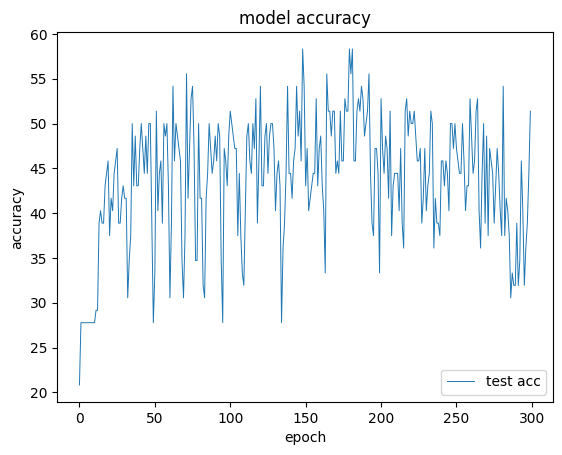

In [ ]:
# run model training
model_training.run()

In [ ]:
probs       = model.forward(X_test.cuda().float())
preds       = probs.argmax(axis = -1)

# Move Y_test to the same device as preds
Y_test = Y_test.to(preds.device)

acc = (preds == Y_test.argmax(axis=-1)).float().mean().item()
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.361111 


In [ ]:
Y_test_normalized = Y_test.cpu().numpy()
preds_numpy = preds.cpu().numpy()

print("Normalized Y_test: \n", Y_test_normalized)
print("Preds: \n", preds_numpy)

Normalized Y_test: 
 [3 0 1 2 1 0 3 0 3 0 0 0 0 2 2 3 1 2 2 2 3 2 0 2 0 3 1 3 3 2 3 3 2 1 3 2 0
 1 1 1 2 1 3 2 3 1 2 0 3 0 2 3 0 2 0 1 1 0 3 0 3 2 2 0 2 1 1 0 2 0 1 0]
Preds: 
 [3 0 0 2 0 0 3 0 2 1 1 1 1 3 2 0 0 0 2 0 0 2 0 3 0 1 1 3 3 2 3 0 0 0 3 2 1
 0 1 1 2 1 3 3 3 2 2 0 3 0 3 2 0 2 1 0 0 0 2 0 3 2 2 1 3 1 0 3 3 1 0 0]


<Axes: title={'center': 'LMDA'}, xlabel='Predicted label', ylabel='True label'>

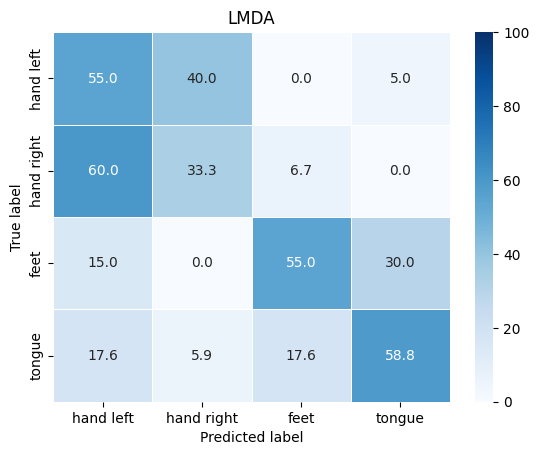

In [ ]:
from matplotlib import pyplot as plt
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix

names = ['hand left', 'hand right', 'feet', 'tongue']
plt.figure(0)

plot_confusion_matrix(Y_test_normalized, preds_numpy, np.array(names), title='LMDA')